## PAW wavelet decomposition

In [1]:
prefix = '/home/ines/repositories/'
prefix = '/Users/ineslaranjeira/Documents/Repositories/'

In [2]:
""" 
IMPORTS
"""
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"
import numpy as np
import pandas as pd
from one.api import ONE
from matplotlib import pyplot as plt
from scipy import stats

# Get my functions
from functions import idxs_from_files, fast_wavelet_morlet_convolution_parallel, get_speed
one = ONE(mode='remote')

RuntimeError: This version of jaxlib was built using AVX instructions, which your CPU and/or operating system do not support. You may be able work around this issue by building jaxlib from source.

In [3]:
""" 
LOAD DATA AND PARAMETERS
"""
# LOAD DATA

data_path = prefix + 'representation_learning_variability/paper-individuality/data/design_matrices/'
# data_path = prefix + 'representation_learning_variability/paper-individuality/data/temp/'

results_path = prefix + 'representation_learning_variability/paper-individuality/data/paw_wavelets/'
all_files = os.listdir(data_path)
design_matrices = [item for item in all_files if 'design_matrix' in item and 'standardized' not in item]
idxs, mouse_names = idxs_from_files(design_matrices)

# Wavelet decomposition
f = np.array([.25, .5, 1, 2, 4, 8, 16, 32])
omega0 = 5
velocity = True

In [5]:
# Loop through animals
files = os.listdir(results_path)
sessions_to_process = []

for m, mat in enumerate(idxs):
    mouse_name = mat[37:]
    session = mat[:36]

    """ SAVE DATA """       
    # Save wavelets
    if velocity:
        subname = "paw_vel_wavelets_"
    else:
        subname = "paw_pos_wavelets_"
    filename = subname + str(session) + '_'  + mouse_name

    if filename not in files:
        sessions_to_process.append((session))

len(sessions_to_process)

218

# Paw wavelets

In [6]:
concatenated_subsampled = np.array([])
paws = ['l_paw', 'r_paw']

for m, mat in enumerate(sessions_to_process[1:2]):

    file_path = one.eid2path(mat)
    if prefix == '/home/ines/repositories/':
        mouse_name = file_path.parts[8]
    else:
        mouse_name = file_path.parts[7]

    session = mat
    filename = data_path + "design_matrix_" + str(session) + '_'  + mouse_name
    design_matrix = pd.read_parquet(filename)
    
    if velocity:
        left_speeds = get_speed(design_matrix, design_matrix['Bin'], 'left', 60, split=True, feature='l_paw')
        right_speeds = get_speed(design_matrix, design_matrix['Bin'], 'right', 60, split=True, feature='r_paw')
        
    for v, var in enumerate(paws):
        for c, coor in enumerate(['_x', '_y']):
            if velocity:
                # If velocity, no z-score before wavelets
                array = np.array(left_speeds[c+1]) if var=='l_paw' else np.array(right_speeds[c+1])
            else:
                # If position, z-score before wavelets
                design_matrix[var+coor] = stats.zscore(np.array(design_matrix[var+coor]), 
                                                    nan_policy='omit', axis=0)  #stats.zscore(data_df[paw_vars], axis=0)
                array = np.array(design_matrix[var+coor]) 
            not_nan = ~np.isnan(array)
            clean_array = array[not_nan]# np.array(stats.zscore(design_matrix[var][not_nan_x]))
            
            # Wavelet decomposition of paw position
            dt = np.round(np.mean(np.diff(design_matrix['Bin'])), 3)
            amp, Q, x_hat = fast_wavelet_morlet_convolution_parallel(clean_array, f, omega0, dt)

            # Wavelet transforms
            for i, frequency in enumerate(f):
                # Create new column with frequency
                design_matrix[str(var+coor+str(frequency))] = np.nan
                design_matrix[str(var+coor+str(frequency))][not_nan] = amp[i, :]

    """ SAVE DATA """       
    # Save wavelets
    if velocity:
        subname = "paw_vel_wavelets_"
    else:
        subname = "paw_pos_wavelets_"
    filename = results_path + subname + str(session) + '_'  + mouse_name
    # design_matrix.to_parquet(filename, compression='gzip')  
    print(mat)

/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/scikits/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/scikits/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)
/home/ines/miniconda3/envs/iblenv/lib/python3.10/site-packages/scikits/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is 

671c7ea7-6726-4fbe-adeb-f89c2c8e489b


/home/ines/repositories/representation_learning_variability/paper-individuality/0_pre-processing/functions.py:392: ComplexWarning: Casting complex values to real discards the imaginary part
  Q[i, :] = q
/tmp/ipykernel_13615/4054287300.py:41: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

In [8]:
use_data = design_matrix.loc[(design_matrix['Bin']> 200) & (design_matrix['Bin']< 500)]

In [27]:
import seaborn as sns
palette = sns.color_palette('Greys')

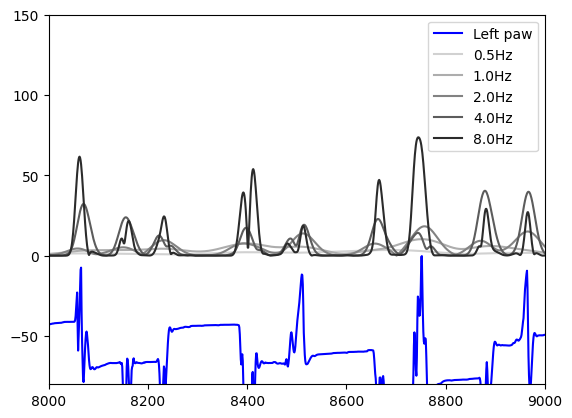

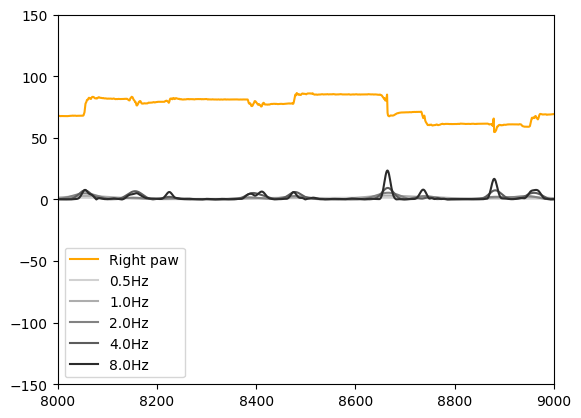

In [66]:
plt.plot(use_data['l_paw_x']/2-400, label='Left paw', color='Blue')
for i, e in enumerate(['l_paw_x0.5','l_paw_x1.0', 'l_paw_x2.0', 'l_paw_x4.0', 'l_paw_x8.0']):
    plt.plot(use_data[e]/2, label=e[-3:]+'Hz', color=palette[i+1])
    plt.legend()
    plt.xlim([8000, 9000])
    plt.ylim([-80, 150])
plt.show()
    
plt.plot(use_data['r_paw_x']-100, label='Right paw', color='Orange')
for i, e in enumerate(['r_paw_x0.5','r_paw_x1.0', 'r_paw_x2.0', 'r_paw_x4.0', 'r_paw_x8.0']):
    plt.plot(use_data[e], label=e[-3:]+'Hz', color=palette[featurei+1])
    plt.legend()
    plt.xlim([8000, 9000])
    plt.ylim([-150, 150])



(array([2.68629e+05, 9.10600e+03, 2.44000e+03, 7.86000e+02, 2.27000e+02,
        6.10000e+01, 9.00000e+00, 3.00000e+00, 1.00000e+00, 1.00000e+00]),
 array([  -4.63202112,  454.1621997 ,  912.95642051, 1371.75064133,
        1830.54486215, 2289.33908297, 2748.13330379, 3206.92752461,
        3665.72174543, 4124.51596625, 4583.31018707]),
 <BarContainer object of 10 artists>)

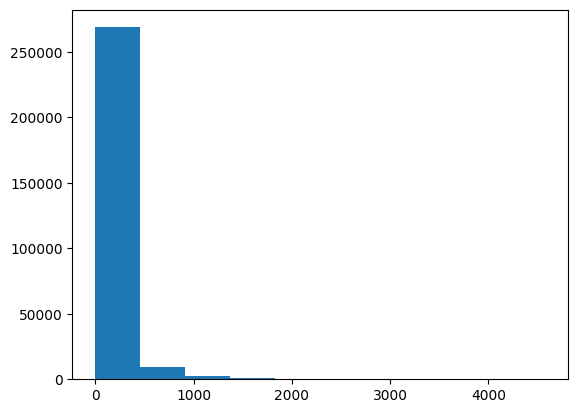

In [32]:
plt.hist(left_speeds[1])

## Data exploration

In [73]:
from scipy.stats import linregress
from sklearn.linear_model import LinearRegression

/tmp/ipykernel_19537/336160730.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


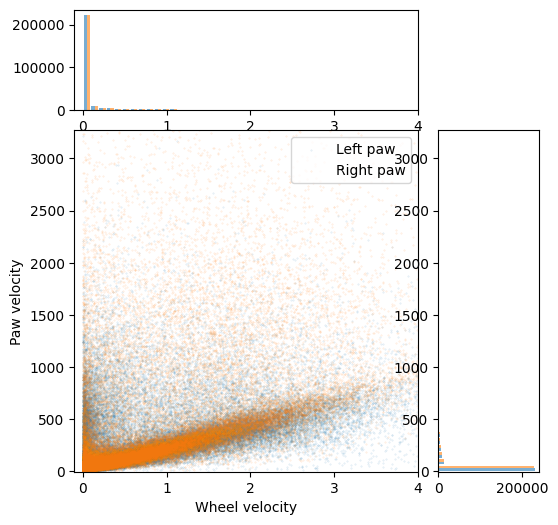

/tmp/ipykernel_19537/336160730.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


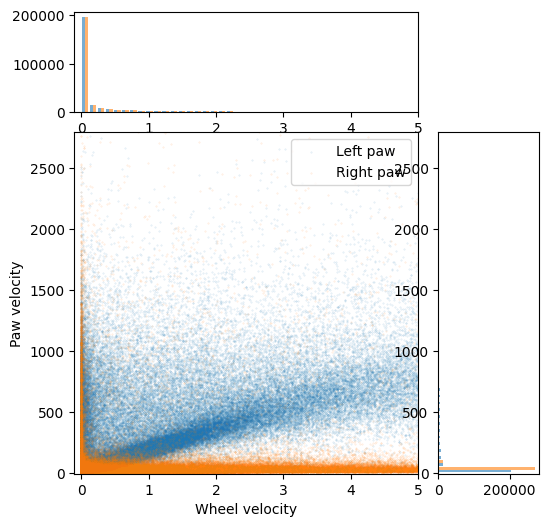

/tmp/ipykernel_19537/336160730.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


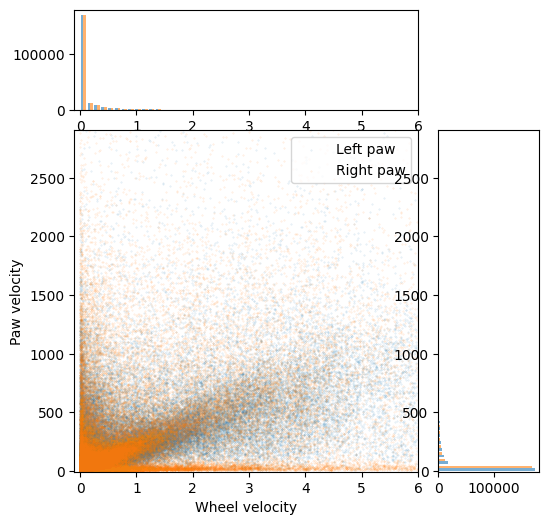

/tmp/ipykernel_19537/336160730.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


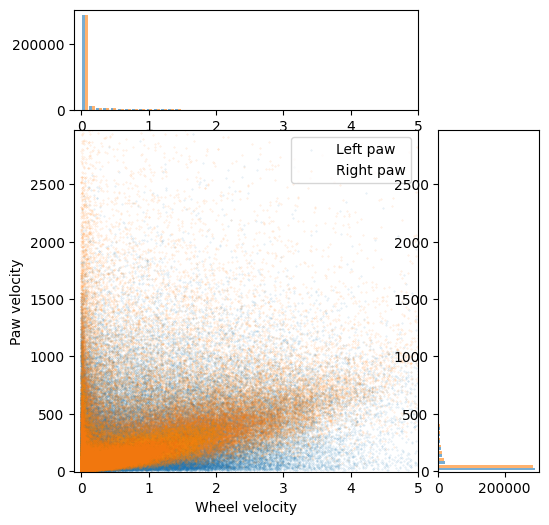

/tmp/ipykernel_19537/336160730.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


KeyboardInterrupt: 

In [76]:
paws = ['l_paw', 'r_paw']

for m, mat in enumerate(sessions_to_process[:10]):

    file_path = one.eid2path(mat)
    if prefix == '/home/ines/repositories/':
        mouse_name = file_path.parts[8]
    else:
        mouse_name = file_path.parts[7]

    session = mat
    filename = data_path + "design_matrix_" + str(session) + '_'  + mouse_name
    design_matrix = pd.read_parquet(filename)
    left_speeds = get_speed(design_matrix, design_matrix['Bin'], 'left', 60, split=False, feature='l_paw')
    right_speeds = get_speed(design_matrix, design_matrix['Bin'], 'right', 60, split=False, feature='r_paw')
    
    # Create main figure
    fig = plt.figure(figsize=(6, 6))
    grid = plt.GridSpec(4, 4, hspace=0.2, wspace=0.2)

    # Define areas
    main_ax = fig.add_subplot(grid[1:4, 0:3])
    x_hist = fig.add_subplot(grid[0, 0:3], sharex=main_ax)
    y_hist = fig.add_subplot(grid[1:4, 3], sharey=main_ax)

    # Scatterplot (two hues)
    main_ax.scatter(np.abs(design_matrix['avg_wheel_vel']), left_speeds[1], alpha=0.2, s=.1, label='Left paw', color='C0')
    main_ax.scatter(np.abs(design_matrix['avg_wheel_vel']), right_speeds[1], alpha=0.2, s=.1, label='Right paw', color='C1')
    main_ax.legend()
    
    # --- Fit and plot regression lines ---
    x1 = x2 = np.array(np.abs(design_matrix['avg_wheel_vel']))
    y1 = left_speeds[1]
    y2 = right_speeds[1]
    
    # # Fit and plot for each group
    # model = LinearRegression()
    # for x, y, color, label in [(x1, y1, 'C0', 'Group 1'), (x2, y2, 'C1', 'Group 2')]:
    #     model.fit(x.reshape(-1, 1), y)
    #     xs = np.linspace(x.min(), x.max(), 100)
    #     ys = model.predict(xs.reshape(-1, 1))
    #     plt.plot(xs, ys, color=color, linewidth=2)


    main_ax.legend()


    # Marginal histograms
    y_hist.hist([left_speeds[1],right_speeds[1]], bins=100, color=['C0', 'C1'], alpha=0.6, orientation='horizontal')
    x_hist.hist([np.abs(design_matrix['avg_wheel_vel']), np.abs(design_matrix['avg_wheel_vel'])], bins=100, color=['C0', 'C1'], alpha=0.6)

    # Hide tick labels on shared axes
    # x_hist.set_xticks([])
    # y_hist.set_yticks([])
    main_ax.set_ylim([-5, int(np.nanmax([left_speeds[1], right_speeds[1]])/2)])
    main_ax.set_xlim([-.1, int(np.nanmax(np.abs(design_matrix['avg_wheel_vel']))/2)])
    main_ax.set_xlabel('Wheel velocity')
    main_ax.set_ylabel('Paw velocity')
    plt.tight_layout()
    plt.show()

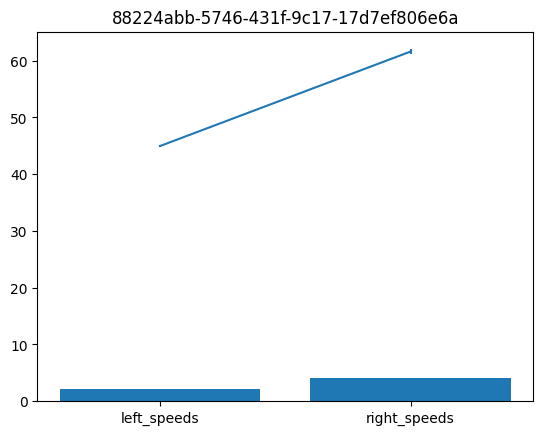

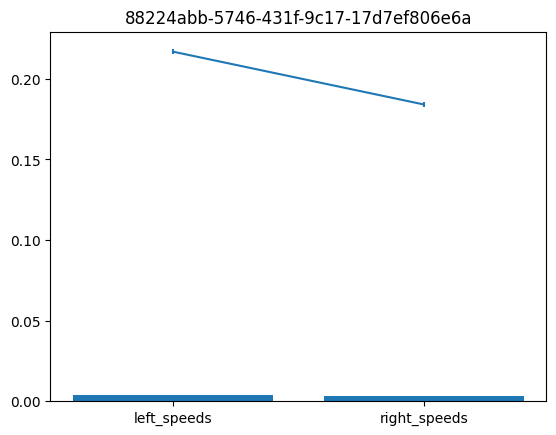

88224abb-5746-431f-9c17-17d7ef806e6a


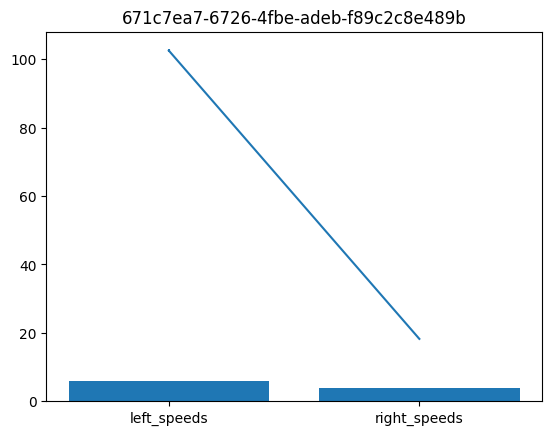

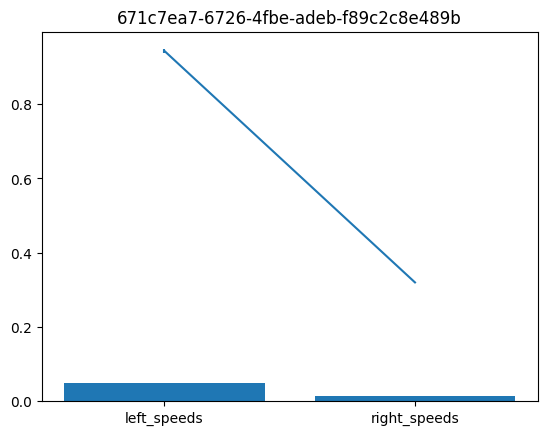

671c7ea7-6726-4fbe-adeb-f89c2c8e489b


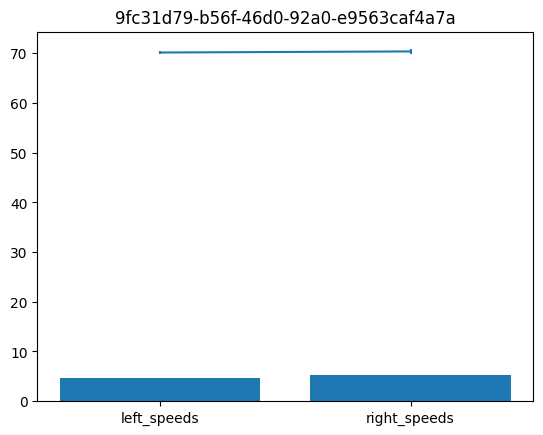

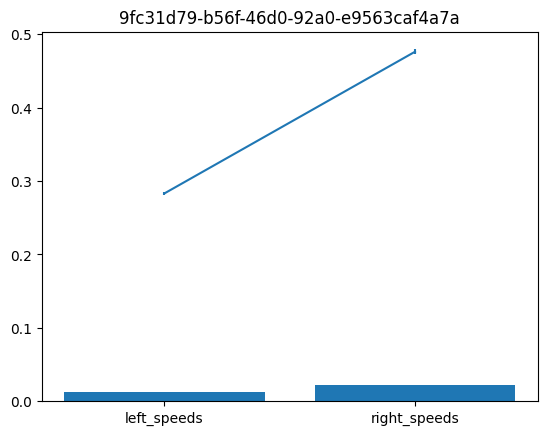

9fc31d79-b56f-46d0-92a0-e9563caf4a7a


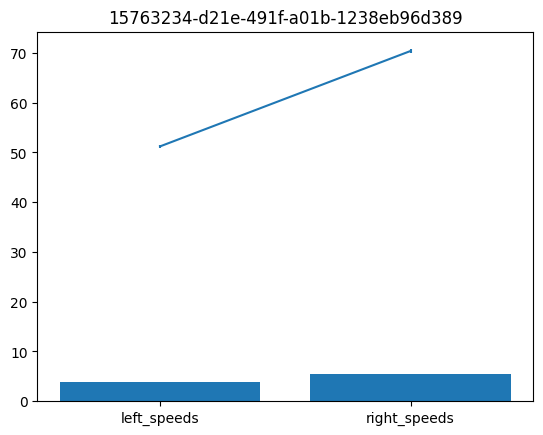

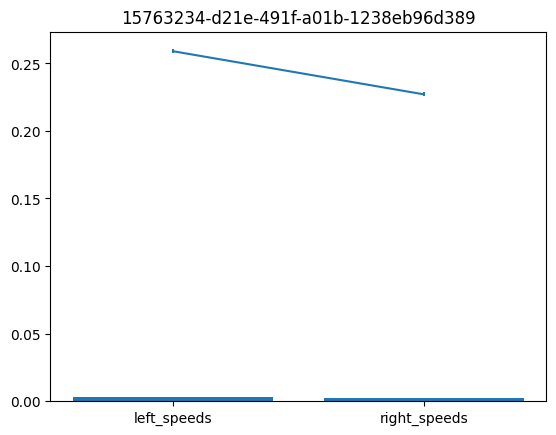

15763234-d21e-491f-a01b-1238eb96d389


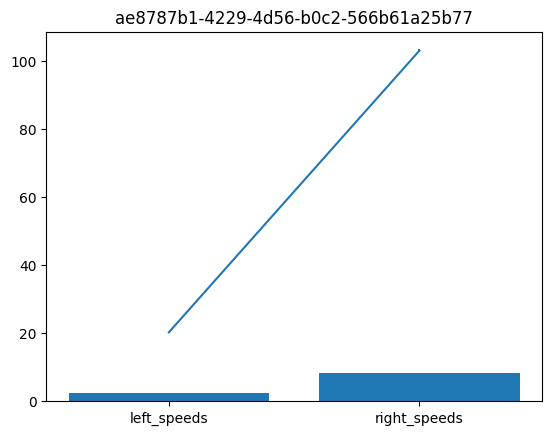

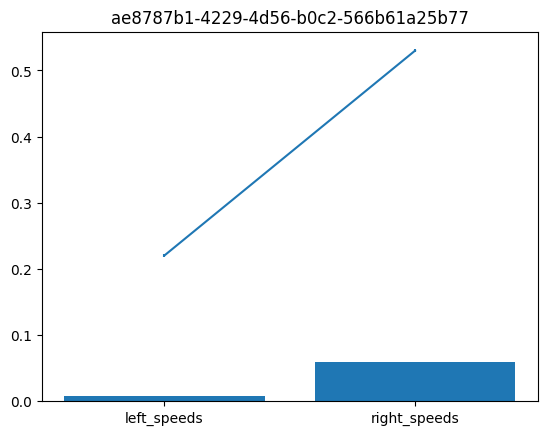

ae8787b1-4229-4d56-b0c2-566b61a25b77


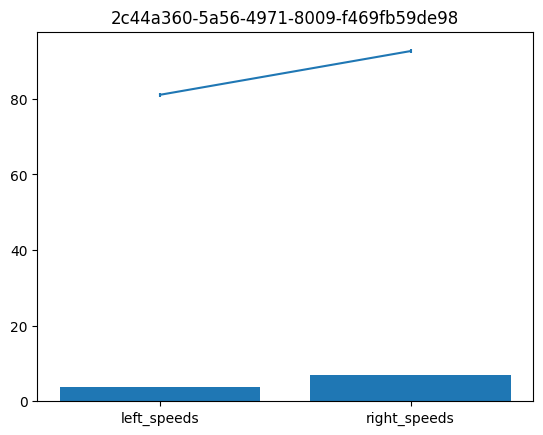

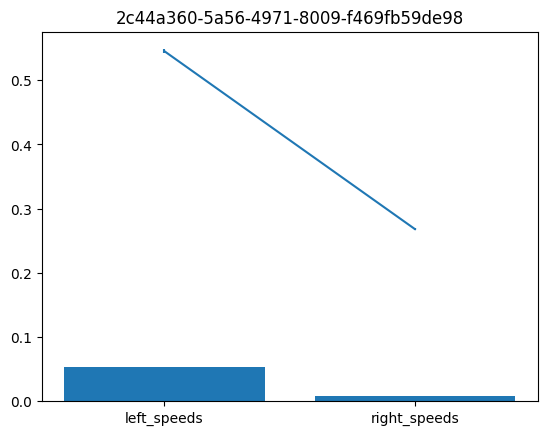

2c44a360-5a56-4971-8009-f469fb59de98


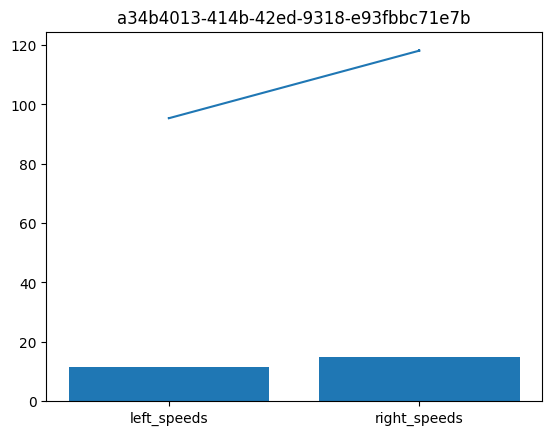

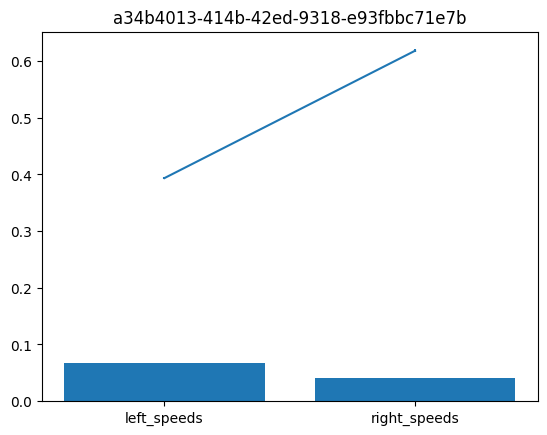

a34b4013-414b-42ed-9318-e93fbbc71e7b


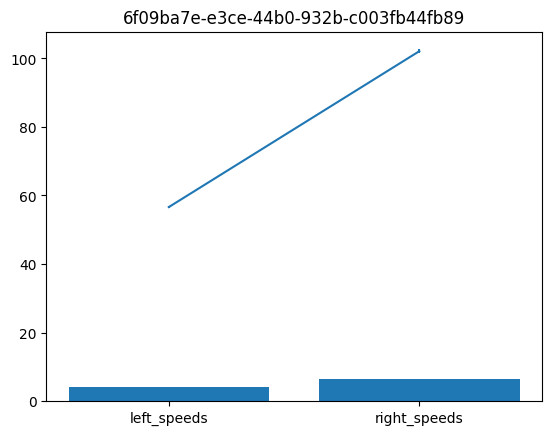

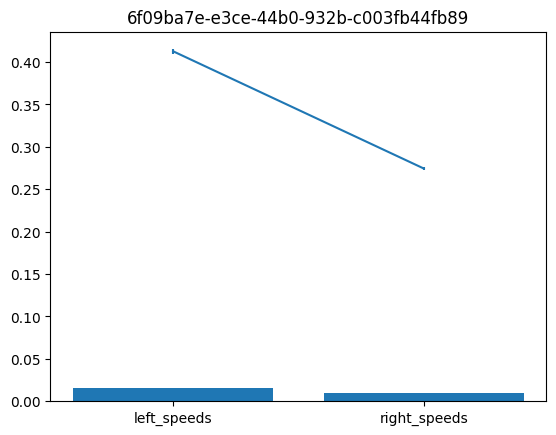

6f09ba7e-e3ce-44b0-932b-c003fb44fb89


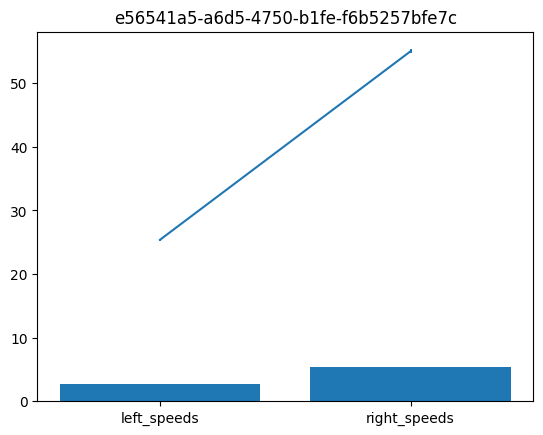

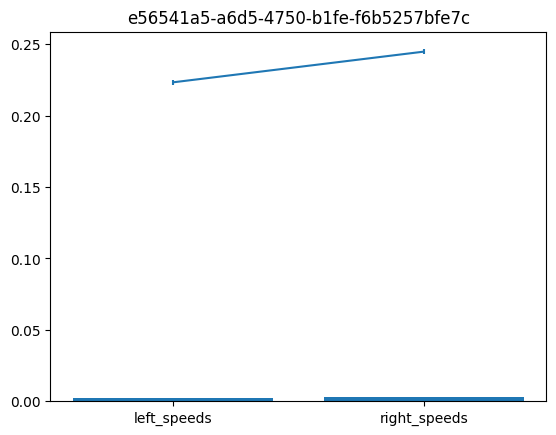

e56541a5-a6d5-4750-b1fe-f6b5257bfe7c


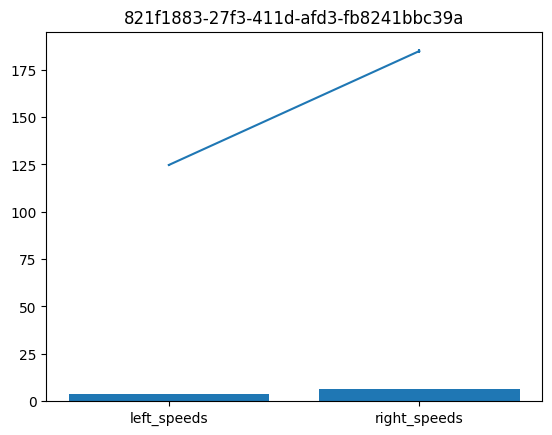

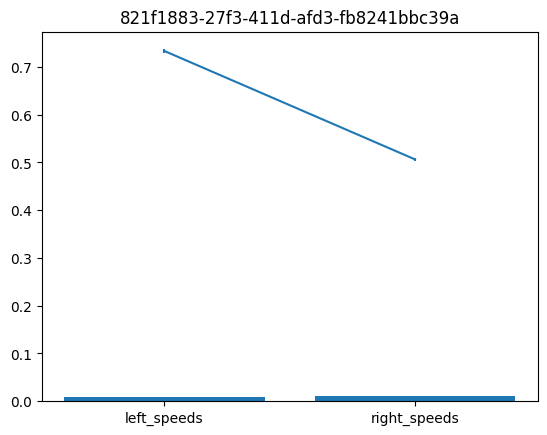

821f1883-27f3-411d-afd3-fb8241bbc39a


In [8]:
paws = ['l_paw', 'r_paw']

for m, mat in enumerate(sessions_to_process[:10]):

    file_path = one.eid2path(mat)
    if prefix == '/home/ines/repositories/':
        mouse_name = file_path.parts[8]
    else:
        mouse_name = file_path.parts[7]

    session = mat
    filename = data_path + "design_matrix_" + str(session) + '_'  + mouse_name
    design_matrix = pd.read_parquet(filename)
    left_speeds = get_speed(design_matrix, design_matrix['Bin'], 'left', 60, split=True, feature='l_paw')
    right_speeds = get_speed(design_matrix, design_matrix['Bin'], 'right', 60, split=True, feature='r_paw')
    
    plt.bar(['left_speeds', 'right_speeds'],
            [np.nanmedian(np.abs(left_speeds[1])), np.nanmedian(np.abs(right_speeds[1]))])
    plt.errorbar(['left_speeds', 'right_speeds'],
            [np.nanmean(np.abs(left_speeds[1])), np.nanmean(np.abs(right_speeds[1]))],
            [np.nanstd(np.abs(left_speeds[1]))/np.sqrt(len(left_speeds[1])), np.nanstd(np.abs(right_speeds[1]))/np.sqrt(len(right_speeds[1]))])
    plt.title(mat)
    plt.show()
    plt.bar(['left_speeds', 'right_speeds'],
            [np.median(np.abs(design_matrix.loc[design_matrix['avg_wheel_vel']<0, 'avg_wheel_vel'])), 
             np.median(np.abs(design_matrix.loc[design_matrix['avg_wheel_vel']>0, 'avg_wheel_vel']))])
    plt.errorbar(['left_speeds', 'right_speeds'],
                 [np.mean(np.abs(design_matrix.loc[design_matrix['avg_wheel_vel']<0, 'avg_wheel_vel'])), 
                np.mean(np.abs(design_matrix.loc[design_matrix['avg_wheel_vel']>0, 'avg_wheel_vel']))], 
                 [np.nanstd(np.abs(design_matrix.loc[design_matrix['avg_wheel_vel']<0, 'avg_wheel_vel']))/np.sqrt(len(design_matrix.loc[design_matrix['avg_wheel_vel']<0, 'avg_wheel_vel'])), 
              np.nanstd(np.abs(design_matrix.loc[design_matrix['avg_wheel_vel']>0, 'avg_wheel_vel']))/np.sqrt(len(design_matrix.loc[design_matrix['avg_wheel_vel']>0, 'avg_wheel_vel']))])
    plt.title(mat)
    plt.show()
    print(mat)
        

/tmp/ipykernel_12118/91921355.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1, 1].legend()


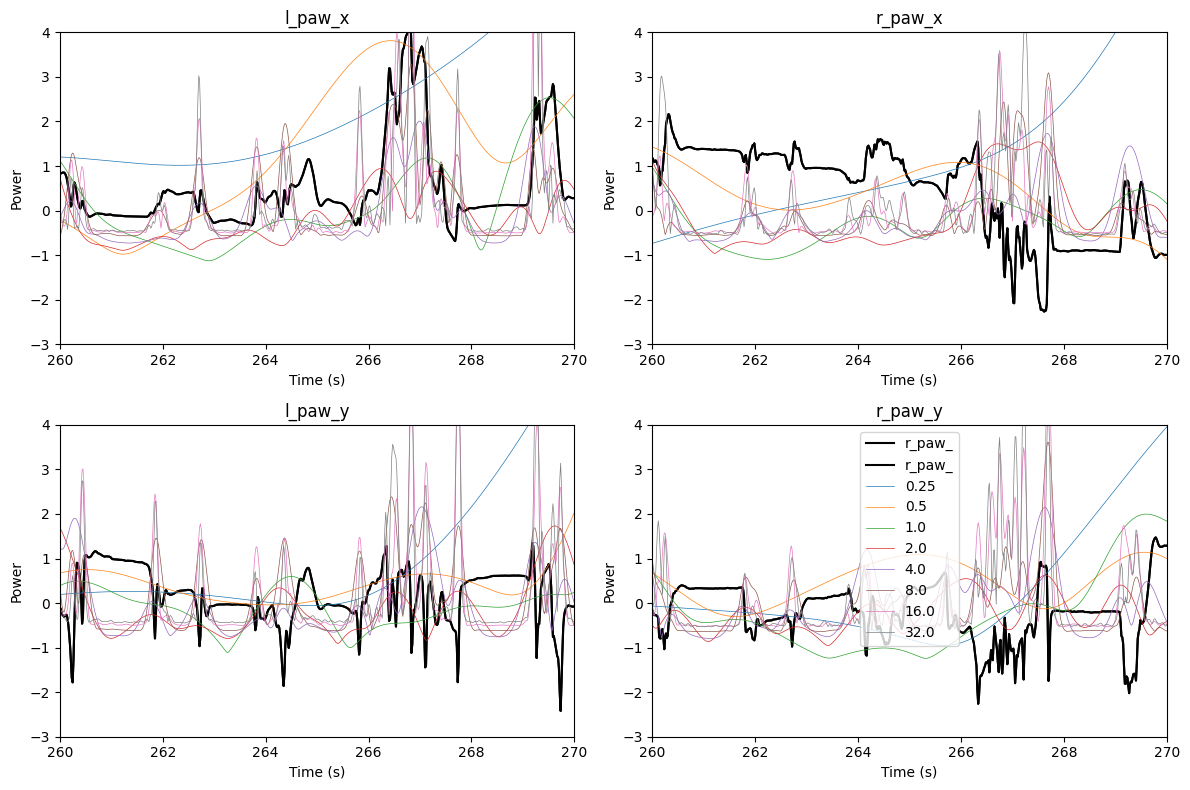

In [135]:
init = 260
fig, ax = plt.subplots(figsize=(12, 8), nrows=2, ncols=2)
for v, var in enumerate(['l_paw_', 'r_paw_']):
    for c, coor in enumerate(['x', 'y']):
        ax[c, v].plot(design_matrix['Bin'], stats.zscore(design_matrix[var+coor], nan_policy='omit'), label=var, color='k')
        ax[c, v].plot(design_matrix['Bin'], stats.zscore(design_matrix[var+coor], nan_policy='omit'), label=var, color='k')
        # Wavelet transforms
        for i, frequency in enumerate(f):
            ax[c, v].plot(design_matrix['Bin'], stats.zscore(design_matrix[var+coor+str(frequency)], 
                                                             nan_policy='omit'), label=str(frequency), linewidth=.5)
            ax[c, v].set_xlim([init, init+10])
            ax[c, v].set_ylim([-3, 4])
            ax[c, v].set_ylabel('Power')
            ax[c, v].set_xlabel('Time (s)')
        ax[c, v].set_title(var+coor)
    ax[1, 1].legend()
    plt.tight_layout()

/tmp/ipykernel_12118/4288006091.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1, 1].legend()


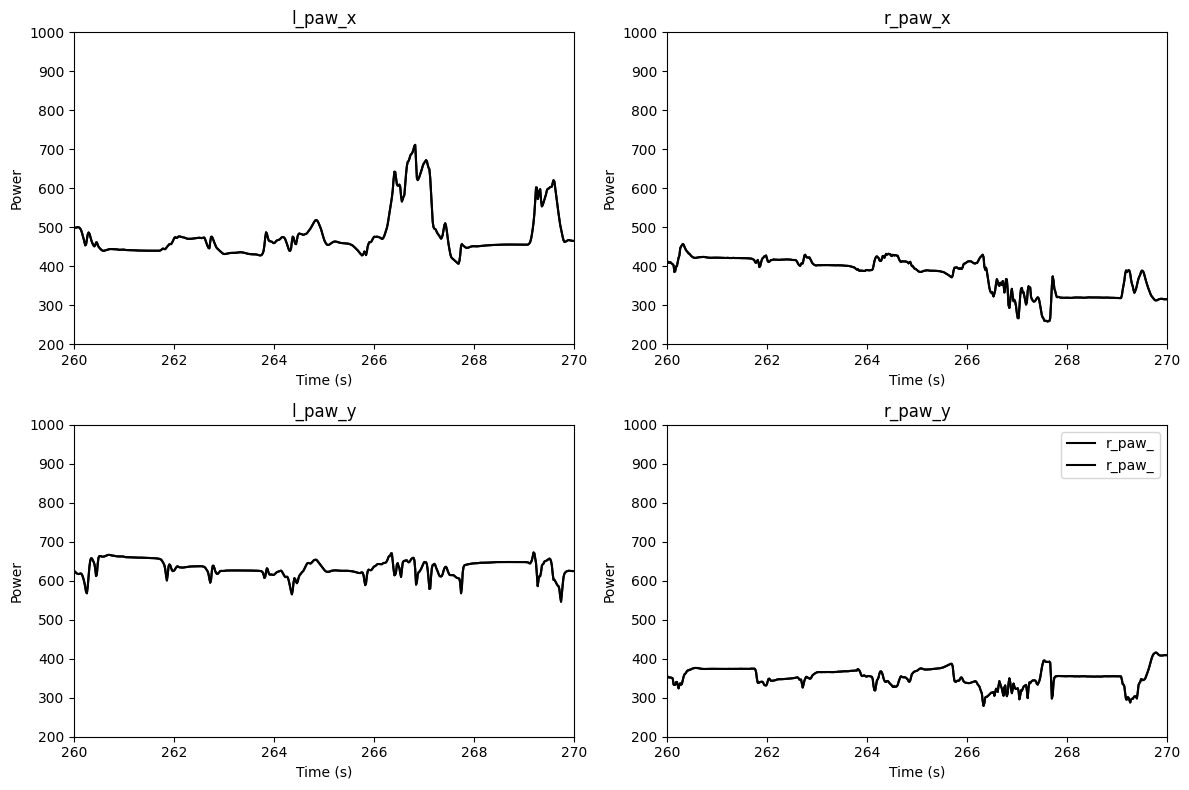

In [136]:
init = 260
fig, ax = plt.subplots(figsize=(12, 8), nrows=2, ncols=2)
for v, var in enumerate(['l_paw_', 'r_paw_']):
    for c, coor in enumerate(['x', 'y']):
        ax[c, v].plot(design_matrix['Bin'], design_matrix[var+coor], label=var, color='k')
        ax[c, v].plot(design_matrix['Bin'], design_matrix[var+coor], label=var, color='k')

        ax[c, v].set_xlim([init, init+10])
        ax[c, v].set_ylim([200, 1000])
        ax[c, v].set_ylabel('Power')
        ax[c, v].set_xlabel('Time (s)')
        ax[c, v].set_title(var+coor)
    ax[1, 1].legend()
    plt.tight_layout()

/tmp/ipykernel_19537/3896101047.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1, 1].legend()


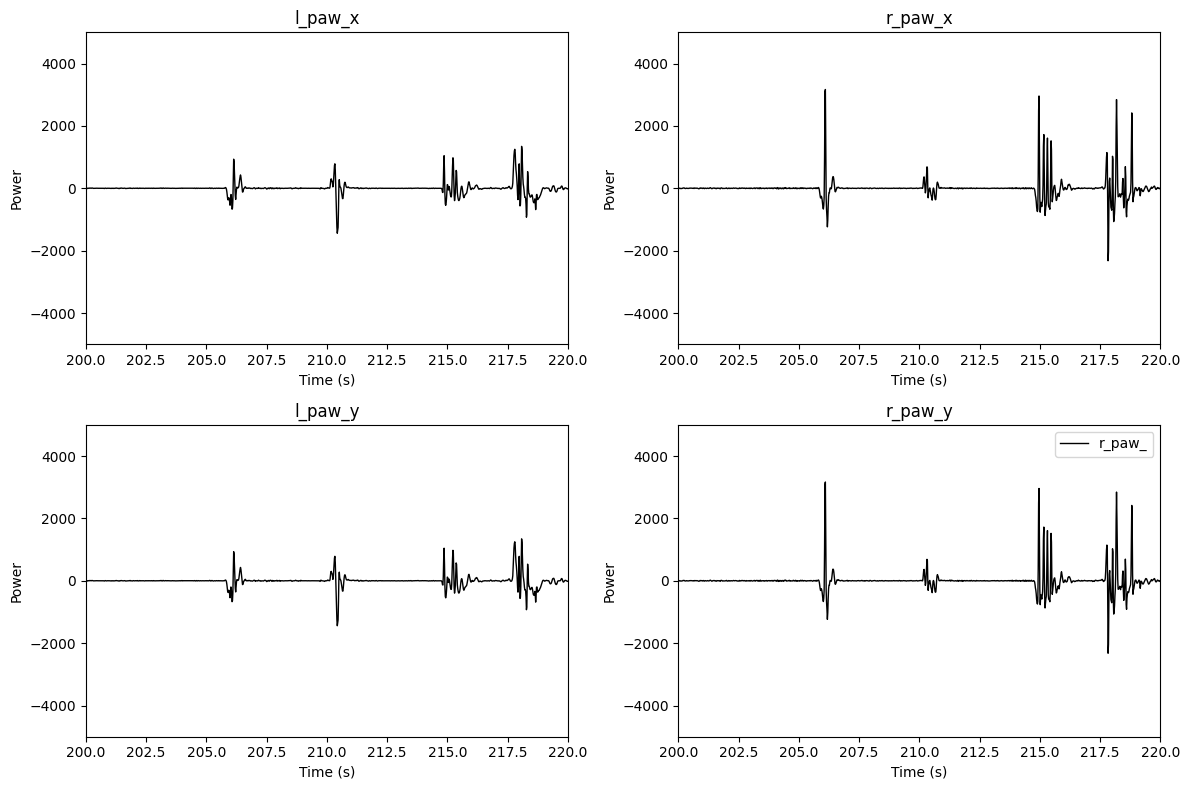

In [11]:
init = 200
fig, ax = plt.subplots(figsize=(12, 8), nrows=2, ncols=2)
for v, var in enumerate(['l_paw_', 'r_paw_']):
    for c, coor in enumerate(['x', 'y']):
        # ax[c, v].plot(design_matrix['Bin'], stats.zscore(design_matrix[var+coor], nan_policy='omit'), label=var, color='k')
        # if var == 'l_paw_':
        #     ax[c, v].plot(design_matrix['Bin'], stats.zscore(left_speeds[1], nan_policy='omit'), label=var, color='k', linewidth=1)
        # elif var == 'r_paw_':
        #     ax[c, v].plot(design_matrix['Bin'], stats.zscore(right_speeds[1], nan_policy='omit'), label=var, color='k', linewidth=1)
        # ax[c, v].plot(design_matrix['Bin'], stats.zscore(design_matrix[var+coor], nan_policy='omit'), label=var, color='k')
        if var == 'l_paw_':
            ax[c, v].plot(design_matrix['Bin'], left_speeds[1], label=var, color='k', linewidth=1)
        elif var == 'r_paw_':
            ax[c, v].plot(design_matrix['Bin'], right_speeds[1], label=var, color='k', linewidth=1)
        # Wavelet transforms
        # for i, frequency in enumerate(f):
        #     # ax[c, v].plot(design_matrix['Bin'], stats.zscore(design_matrix[var+coor+str(frequency)], 
        #     #                                                  nan_policy='omit')+2, label=str(frequency), linewidth=.8)
        #     ax[c, v].plot(design_matrix['Bin'], design_matrix[var+coor+str(frequency)]+2, label=str(frequency), linewidth=.8)
        ax[c, v].set_xlim([init, init+20])
        ax[c, v].set_ylim([-5000, 5000])
        ax[c, v].set_ylabel('Power')
        ax[c, v].set_xlabel('Time (s)')
        ax[c, v].set_title(var+coor)
    ax[1, 1].legend()
    plt.tight_layout()